# 5 - Vocoder and Quantization

## 2) LPC-Vocoder: Analysis

In this section we revise some of the techniques we have familiarized ourselves with during the previous exercise sessions.

We import some utilities.
Make sure that you have the python package [spectrum](https://github.com/cokelaer/spectrum/) installed.

In [1]:
include("./JuliaImpl/SSP.jl")
include("./JuliaImpl/Sheet1.jl");
include("./JuliaImpl/Sheet2.jl");
include("./JuliaImpl/Sheet3.jl");
include("./JuliaImpl/Sheet5.jl");
using SSP;
using Plots;
using PyCall

@pyimport spectrum

female = loadAudio("./Exercise5/female8khz.wav")

SSP.Audio([-0.000427259; 6.1037e-5; … ; 3.05185e-5; 3.05185e-5], 8000.0, 0.0)

### 2.1) Segmentation

_Q: Why do we process segments of the signal instead of the whole signal?_

The signal is not homogeneous and consists of regions which have distinct qualities (e.g. silent, voiced, unvoiced).
For speech processing in particular we are interested in identifying single phonemes, which in general have a short duration.
It therefore makes sense to analyse at a similar scale.

_Q: Is a segment length of 32ms appropriate? Why or why not?_

Suppose we have a 32ms window of a voiced segment at 100Hz (male voice).
Such a segment would contain `3.2 = 32e-3 * 100` fundamental periods.
For a female voice at 200Hz this segment would contain 6.2 periods.

Of course 2 period lengths is the barest minimum of periods you need to detect a period.
32ms therefore is a very small window for male voices, but a decent one for female voices.
Also note that many phonemes which occur within a words have a duration of, say, 50ms long.
To keep processing times short, we don't want to have too small frame shifts so that a 32ms frame would be a good compromise, which has a decent probability of capturing a good part of a 50ms phoneme.


### 2.2) Signal Power

We define `computePower` for `Vector`, `Audio` and `FramedAudio`.

```julia
# ./JuliaImpl/Sheet5.jl
function computePower(signal::Vector{Float64})
    mean(signal .^ 2)
end

function computePower(faudio::FramedAudio)
    mean(faudio.samples .^ 2, 1)
end

function computePower(faudio::FramedAudio)
    mean(faudio.frames .^ 2, 1)
end
```

### 2.3) Voiced / unvoiced decision

In the source-filter model the voiced sound is created by filtering an excitation signal which is quite regular.
This also means that we do not introduce higher frequencies and that the number of zero crossings is within a small multiple of the number of fundamental periods.

On the other hand, unvoiced segments are, in the model, generated by filtering white noise, which tends to have a lot of high frequency components.
It is in fact the defining property of white noise that its Fourier coefficients all have a similar magnitude.
It is this reason which leads us to expect a much higher count of zero crossings, as we have more (irregular) fluctuations in the signal.

Because we assume a signal $s$ to be fundamentally continuous, we know by the mean value theorem that the signal strength must become zero at least once between samples $i$ and $i+1$, whenever $s_i s_{i+1}$ is negative, i.e. when it switches signs.
Hence we derive the following function to count zero crossings:

```julia
# ./JuliaImpl/Sheet5.jl
function meanZeroCrossings(signal::Vector{Float64})
    signChanges = sign.(signal[1:end-1] .* signal[2:end])
    count(signChanges .< 0) / length(signal)
end

function meanZeroCrossings(faudio::FramedAudio)
    z = zeros(numFrames(faudio))
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,1,i]
        z[i] = meanZeroCrossings(s)
    end
    z
end
```

Using this we can provide a simple voicedness criterion as follows

```julia
# ./JuliaImpl/Sheet5.jl
function isVoiced(x; threshold=0.29)
    0.0 + (meanZeroCrossings(x) .< threshold)
end
```

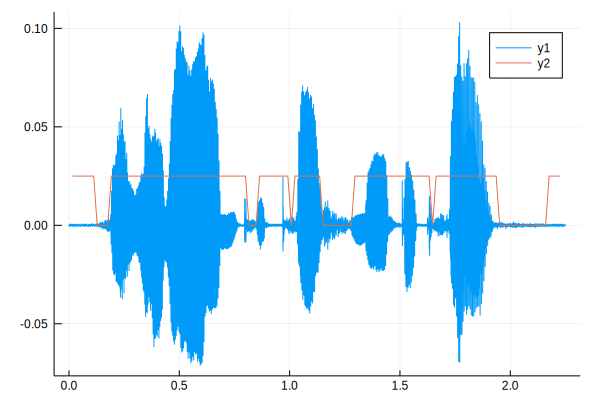

In [2]:
female_frames = Sheet1.my_windowing(female)
female_isVoiced = Sheet5.isVoiced(female_frames, threshold=0.29)
plot([times(female),female_frames.mean_time],
    [female.samples[:,1], 0.025*female_isVoiced])

_Q: Are all speech sounds either voiced or unvoiced?_

In certain African languages you can find words which make use of the clicking tongue.

The clicking of the tongue, as used in certain African languages, is not well modeled by the source-filter model, as the sound is generated by the tongue as opposed to the vocal cords or an outbreath.

### 2.4) Fundamental Frequency Estimation

We reuse our fundamental frequency estimator from sheet 1.

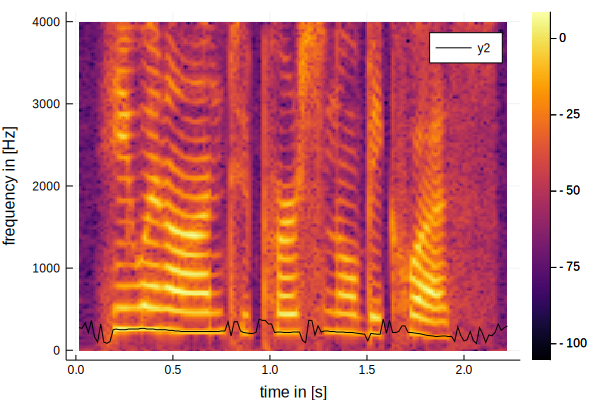

In [3]:
_, female_pitch = Sheet1.fundamentalFrequencyEstimator(female_frames)

p = Sheet2.my_spectrogram(Sheet2.my_stft(Sheet2.applyWindow(female_frames)))
plot!(p, female_frames.mean_time, female_pitch, color="black")

## 2.5) Linear prediction coefficients / linear predictive coding

_Outline:_

1. The source-filter model is a model of how human speech production works.
2. The source-filter model consists of a set of basic signals: white noise as a result of exhalation and an excitation signal which is produced by the vocal cords.
   At any time only one source is active.
   The source controls whether a voiced or an unvoiced sound is produced, as well as the pitch.
3. These signals don't reach the recipient directly but go through a linear convolution step, which models the vocal tract.
The convolution kernel may change over time and controls which phonemes are produced.

In [4]:
a_female = Sheet3.lpc(female_frames);

In [5]:
female.samplingRate

8000.0

TODO: which model order do we need for linear prediction of a signal with audio bandwidth 4kHz? Is the bandwidth even relevant?

## 3) LPC-vocoder: synthesis

### 3.1) LPCs and constant excitation signal

We have two functions which generate our excitation signals

In [6]:
function unvoiced(n::Int;
                  scaling=0.02::Float64)
    scaling * randn(n)
end

function voiced(n::Int, samplingRate::Float64;
                freq=200.0::Float64,
                scaling=0.02::Float64)
    ex = zeros(n)
    ex[1:round(Int, samplingRate/freq):end] = 1
    scaling * ex
end

voiced (generic function with 1 method)

Because Julia does not come with its own `filterAdaptively` implementation, we have to implement it ourselves.
Luckily the `DSP` package provides all the tools we need:

```julia
# ./JuliaImpl/Sheet5.jl
function filterAdaptively(b::Vector{Float64},
                          a::Vector{Float64},
                          x::Vector{Float64};
                          zi=[]::Vector{Float64})
    n = max(length(b), length(a))

    a_ = zeros(n)
    a_[1:length(a)] = a
    b_ = zeros(n)
    b_[1:length(b)] = b
    zi_ = zeros(n-1)
    zi_[1:length(zi)] = zi

    stateful = DF2TFilter(PolynomialRatio(b_, a_), zi_)
    out = filt(stateful, x)
    zo = stateful.state
    (out, zo)
end
```


Finally we perform an LPC analysis and try to recreate the original signal from the LPC coefficients.

In [7]:
function withConstantExcitationSignal(
        audio::Audio, excitation;
        m=12::Int, track=1::Int)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    zi = zeros(m-1)
    result = zeros(0)
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        lpc_coeff = Sheet3.lpc(s, m=m)
        out, zi = Sheet5.filterAdaptively(
            [1.0], vcat(1,lpc_coeff),
            excitation(length(s)), zi=zi)
        append!(result, out)
    end
    loadAudio(result, samplingRate(audio))
end

withConstantExcitationSignal (generic function with 1 method)

In [8]:
female_lpc_voiced_200Hz =
    withConstantExcitationSignal(female,
    n -> voiced(n, samplingRate(female)), m=4);
#playAudio(female_lpc_200Hz);
female_lpc_unvoiced =
    withConstantExcitationSignal(female, unvoiced, m=4);
#playAudio(female_lpc_100Hz);

It is possible to understand what is being said, although it helps to know what the speaker said in the original soundfile. In either case the speech sounds unnatural: Using a pulse train as an excitation signal makes the speaker sound like an martian, while the Gaussian noise makes the speaker sound like she is out of breath.

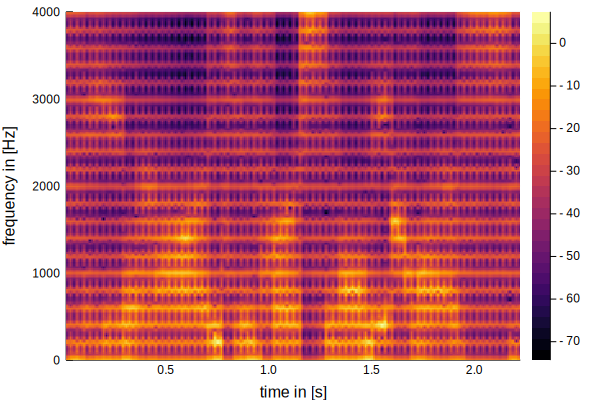

In [9]:
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_lpc_voiced_200Hz))))

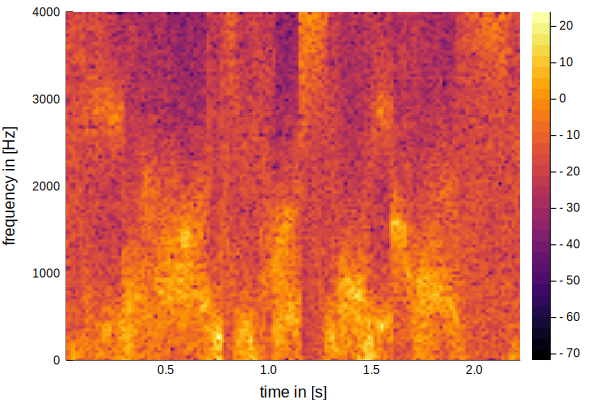

In [10]:
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_lpc_unvoiced))))

### 3.2) Voiced/unvoiced excitation

In [11]:
function voicedAndUnvoiced(
        audio::Audio;
        m=12::Int, track=1::Int, threshold=.29::Float64)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    lpc_coeffs = Sheet3.lpc(faudio, m=m)
    zi = zeros(m-1)
    result = zeros(0)
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        excitation =                                        #
            Sheet5.isVoiced(s, threshold=threshold) ?       #
            voiced(length(s), samplingRate(audio)) : #
            unvoiced(length(s))                      #
        lpc_coeff = Sheet3.lpc(s, m=m)
        out, zi = Sheet5.filterAdaptively(
            [1.0], vcat(1,lpc_coeff), excitation, zi=zi)
        append!(result, out)
    end
    loadAudio(result, samplingRate(audio))
end

voicedAndUnvoiced (generic function with 1 method)

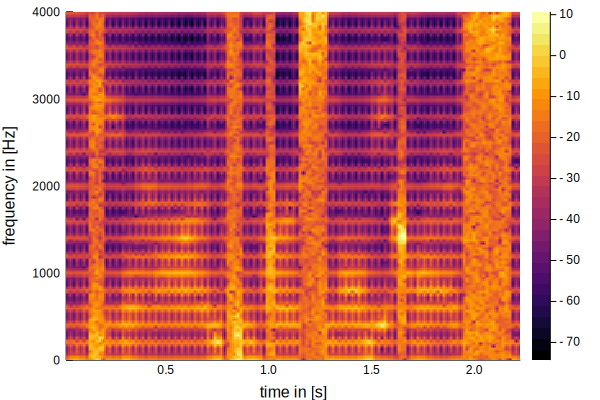

In [12]:
female_voiced_and_unvoiced = voicedAndUnvoiced(female,m=4)
#playAudio(female_voiced_and_unvoiced)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_voiced_and_unvoiced))))

### 3.3) Amplitude modulation

The power $E(s^2)$ of a signal $s$ scales quadratically, i.e. for a constant $\alpha$ we have $E((\alpha s)^2) = \alpha^2 E(s^2)$.
If we have two signals $s_0$ and $s$ and wish to modify $s$ to have the same power as $s_0$, we need

$$ E(s_0^2) = \alpha^2 E(s^2) \implies \alpha = \sqrt{\frac{E(s_0^2)}{E(s^2)}} $$

In [13]:
function withAmplitude(
        audio::Audio;
        m=12::Int, track=1::Int, threshold=.29::Float64)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    lpc_coeffs = Sheet3.lpc(faudio, m=m)
    zi = zeros(m-1)
    result = zeros(0)
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        excitation =
            Sheet5.isVoiced(s, threshold=threshold) ?
            voiced(length(s), samplingRate(audio)) :
            unvoiced(length(s))
        lpc_coeff = Sheet3.lpc(s, m=m)
        out, zi = Sheet5.filterAdaptively(
            [1.0], vcat(1,lpc_coeff), excitation, zi=zi)
        α = sqrt(Sheet5.computePower(s) #
            / Sheet5.computePower(out)) #
        append!(result, α * out)        #
    end
    loadAudio(result, samplingRate(audio))
end

withAmplitude (generic function with 1 method)

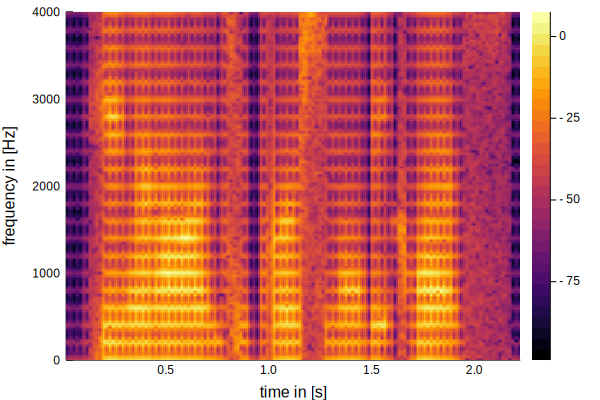

In [14]:
female_withAmplitude = withAmplitude(female,m=4)
#playAudio(female_withAmplitude)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_withAmplitude))))

By adjusting for the signal power we got rid of certain noisy regions, which should have been silent, but were just as loud as the speech signal before.
This is also visible in above spectrogram, when compared with previous ones.

## 3.4) Variable $f_0$

To make the transitions between frames more seamless we keep a counter which helps us to keep track of the (often time-varying) fundamental periods.

In [15]:
function voicedS(length::Int, samplingRate::Float64;
        freq=100.0::Float64, scaling=0.02::Float64,
        counter=0::Int)
    s = zeros(length)
    period = samplingRate / freq
    for i in 1:length
        if counter > period
            counter = 0
            s[i] = scaling
        else
            counter += 1
        end
    end
    (s, counter)
end

voicedS (generic function with 1 method)

In [16]:
function withPitch(
        audio::Audio;
        m=12::Int, track=1::Int, threshold=.29::Float64)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    lpc_coeffs = Sheet3.lpc(faudio, m=m)
    zi = zeros(m-1)
    result = zeros(0)
    counter = 0
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        ff = Sheet1.fundamentalFrequencyEstimator(s,                #
            samplingRate(faudio))                                   #
        voiced, counter = voicedS(length(s), samplingRate(faudio),  #
            freq=ff, counter=counter)                               #
        excitation =
            Sheet5.isVoiced(s, threshold=threshold) ?
            voiced :                                                #
            unvoiced(length(s))
        lpc_coeff = Sheet3.lpc(s, m=m)
        out, zi = Sheet5.filterAdaptively(
            [1.0], vcat(1,lpc_coeff), excitation, zi=zi)
        α = sqrt(Sheet5.computePower(s)
            / Sheet5.computePower(out))
        append!(result, α * out)
    end
    loadAudio(result, samplingRate(audio))
end

withPitch (generic function with 1 method)

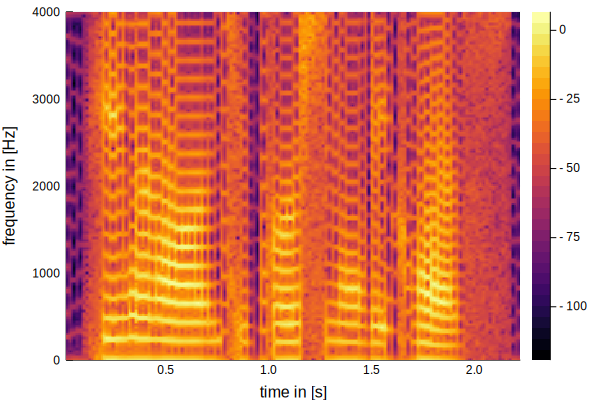

In [17]:
female_withPitch = withPitch(female, m=4)
#playAudio(female_withPitch)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_withPitch))))

This time the voices sounds way less monotonic, but there are still some high-pitched artifacts left.
In the spectrogram you can clearly see that the high frequencies are too strongly pronounced when you compare it with the spectrogram of the original signal.
This does not seem to improve even for larger $m$.

One reason for the artifacts, which are noticeable at the beginning and end of speech segments could be caused by the inadequacy of our voiced/unvoiced categorisation.
If we set the threshold for the mean zero crossings to `0.1` we can extract the artifacts, but the voiced segments are, along with the unvoiced segments, categorised as unvoiced:

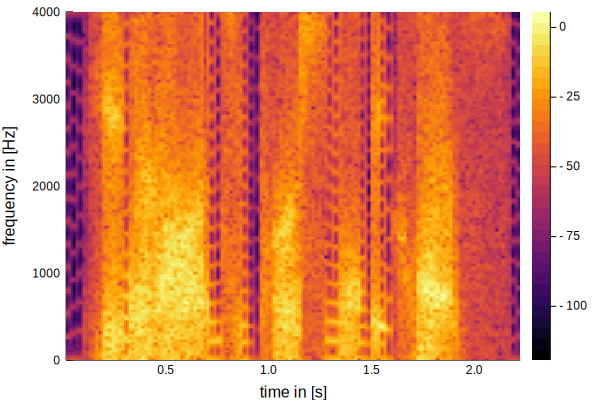

In [18]:
female_withPitch_t = withPitch(female, m=4, threshold=0.1)
#playAudio(female_withPitch_t)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_withPitch_t))))

### 3.5) No LPC

In [19]:
function noLPC(
        audio::Audio;
        m=12::Int, track=1::Int, threshold=.29::Float64)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    lpc_coeffs = Sheet3.lpc(faudio, m=m)
    zi = zeros(m-1)
    result = zeros(0)
    counter = 0
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        ff = Sheet1.fundamentalFrequencyEstimator(s,
            samplingRate(faudio))
        voiced, counter = voicedS(length(s), samplingRate(faudio),
            freq=ff, counter=counter)
        excitation =
            Sheet5.isVoiced(s, threshold=threshold) ?
            voiced : 
            unvoiced(length(s))
        out = excitation                                            #
        α = sqrt(Sheet5.computePower(s)
            / Sheet5.computePower(out))
        append!(result, α * out)
    end
    loadAudio(result, samplingRate(audio))
end

noLPC (generic function with 1 method)

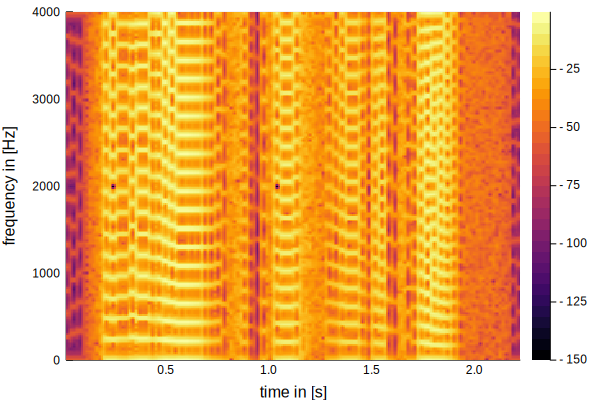

In [20]:
female_nolpc = noLPC(female)
#playAudio(female_nolpc)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_nolpc))))

After cutting out the LPC step, it became impossible to understand what was being said.
This shows how important it is to model the vocal tract and how it changes in order to produce distinguishable sounds.

Among the features of speech we discussed so far it therefore seems that the LPC coefficients are the most important factor to intelligibility.
We have experienced this by recreating the speech by only using the LPC coefficients.
The Voiced/unvoiced distinction, amplitude, and pitch aren't as crucial to understanding.
However they aid us in making the speech sound more human-like and distinguish between intonations.
This is helpful in deciding whether a sentence is a question or a statement.

To visualise the last point we analysed a speaker saying "This is a banana? This is a banana." with two methods `withPitch` and `withConstantExcitationSignal`.

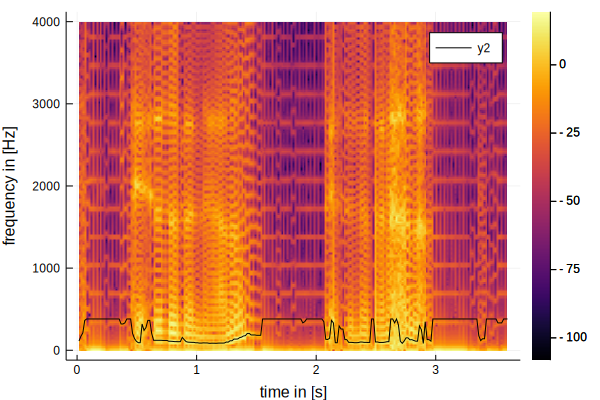

In [21]:
question = loadAudio("./Exercise5/question.wav")
a = withPitch(question,m=8,threshold=0.15)
b = withConstantExcitationSignal(question,unvoiced,m=12)
af = Sheet1.my_windowing(a)
bf = Sheet1.my_windowing(b)
_, pitch = Sheet1.fundamentalFrequencyEstimator(af)
#playAudio(a)
#playAudio(b)

p = Sheet2.my_spectrogram(Sheet2.my_stft(Sheet2.applyWindow(af)))
plot!(p, af.mean_time, pitch, color="black")

## Quantisation

You can encode $2^n$ quantisation levels with $n$ bits.
In case of a mid-rise quantisation and $x_{\max} = -x_{\min}$ a signal value $0$ is not quantised as $0$.

Note that the range of values of a signed integer on $n$ bytes is $-2^n,...,2^n-1$.
For an unsigned integer, the range is $0,...,2^n-1$

For our encoder we will output __unsigned integers__.

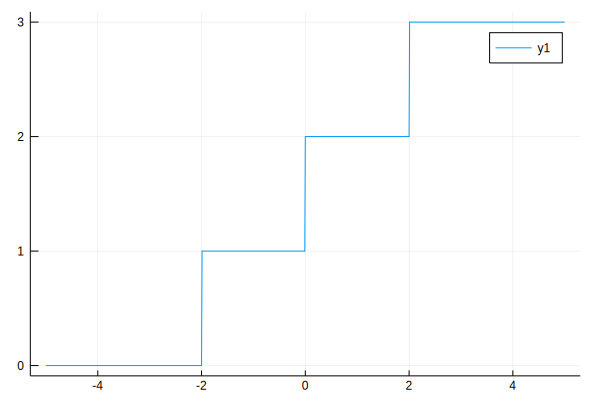

In [22]:
function quantiseEncoder(x::Vector{Float64}, nBits::Int, xMax::Float64, xCenter::Float64)
    xMin = 2*xCenter - xMax
    y = min.(max.(xMin,x),xMax)
    round.(UInt128, (y - xMin)/(xMax-xMin) * (2^nBits-1))
end
plot(-5:0.01:5, t -> quantiseEncoder([t],2,3.0,0.0)[1])

The decoder can be implemented similarly:

In [23]:
function quantiseDecoder(x::Vector{UInt128}, nBits::Int, xMax::Float64, xCenter::Float64)
    xMin = 2*xCenter - xMax
    y = Vector{Float64}(min.(x, 2^nBits-1))
    y * (xMax - xMin) / (2^nBits-1) + xMin
end

quantiseDecoder (generic function with 1 method)

Let's see what happens if we encode and decode right after.
The following plots compares this to the identity function on the interval $(-5,5)$:

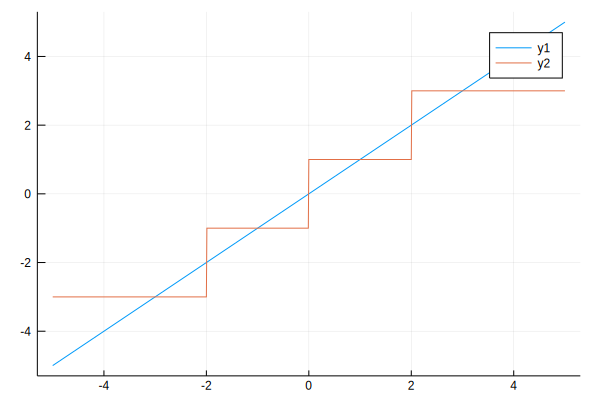

In [24]:
backAndForth = t -> quantiseDecoder(quantiseEncoder([t],2,3.0,0.0),2,3.0,0.0)[1]
plot(-5:0.01:5, [t -> t, backAndForth])

### 4.2) Quantizing the fundamental frequency

The fundamental frequency is, in our model, bounded between 80Hz to 400Hz. Therefore we get `xMax = 400.0` and `xCenter = (400 + 80)/2 = 240.0`.

In [25]:
function ffCoder(signal::Vector{Float64}, nBits::Int)
    xMax = 400.0
    xMin = 80.0
    xCenter = (xMax + xMin) / 2
    quantiseDecoder(quantiseEncoder(signal, nBits, xMax, xCenter), nBits, xMax, xCenter)
end

ffCoder (generic function with 1 method)

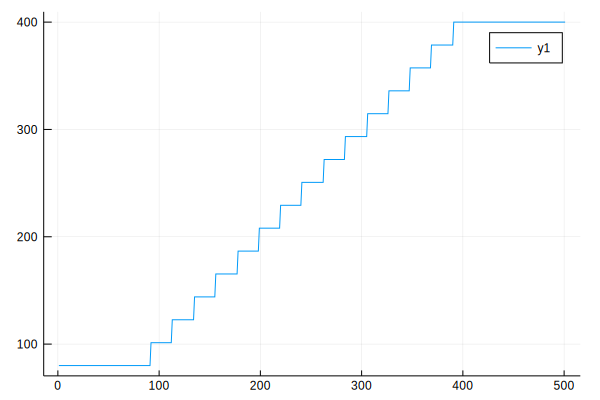

In [26]:
plot(ffCoder(Vector(0.0:500.0),4))

By inserting the line
```julia
        ff = ffCoder([ff], 4)[1]                # (1)
```

in our `withPitch` function we were able to see how the number of bits changes the audio quality.
It seemed like `nBits = 4` was ideal to encode the fundamental frequency: At lower bit counts the loss of quality was very noticeable, whereas a higher number of bits didn't improve the quality drastically.
One way to reduce even this resolution would be to half the window (currently 80Hz - 400Hz) of allowable fundamental frequencies to, say, 80Hz - 240Hz, which could make `nBits = 3` work.

### 4.3) Quantising the signal energy


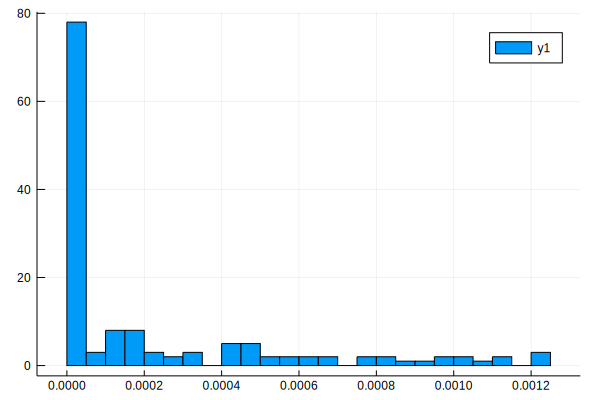

In [27]:
female_power = Sheet5.computePower(female_frames)[1,:]
histogram(female_power, nbins=50)

We observe that most of the power is strongly concentrated around `0.0`.
The 95% quantile lies at:

In [28]:
powerMax = quantile(female_power, 0.95)

0.00100771434839158

With `powerCenter = powerMax / 2` we get

In [29]:
function powerCoder(power::Array{Float64}, nBits::Int)
    xMax = 0.00100771434839158
    xCenter = xMax / 2
    quantiseDecoder(quantiseEncoder(power, nBits, xMax, xCenter), nBits, xMax, xCenter)
end

powerCoder (generic function with 1 method)

We modify `withPitch` now further by adding

```julia
        s_power = powerCoder([Sheet5.computePower(s)], 6)[1]       # (2)
        α = sqrt(s_power                                           # (2)
            / Sheet5.computePower(out))
```

It seems like a value of `nBits = 7` is sufficiently good, but `nBits = 6` works well too with only some minor artifacts occuring. At lower number of bits, the sound tends to cut off.


Ideally the encoder has a high resolution for values close to 0 and a low resolution further away from 0.
By applying the __logarithm__ we can even out the distribution, which allows us to make the most out of our uniform quantiser.

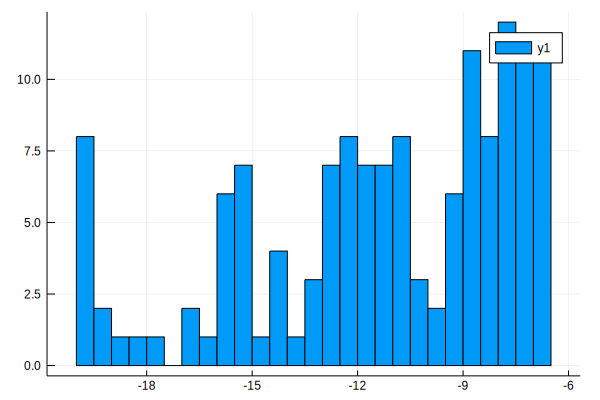

In [30]:
histogram(log.(female_power), nbins=50)

In [31]:
function logPowerCoder(power::Array{Float64}, nBits::Int)
    xMax = -2.0
    xMin = -26.0
    xCenter = (xMax + xMin) / 2
    coded = quantiseEncoder(log.(power), nBits, xMax, xCenter)
    exp.(quantiseDecoder(coded, nBits, xMax, xCenter))
end

logPowerCoder (generic function with 1 method)

Using this modified coding scheme we managed to decrease the amount of bits to `nBits = 4` while retaining a good quality.
Thus coding the logarithmic power shrank the bit rate down by `3` bits per frame!

```julia
s_power = logPowerCoder([Sheet5.computePower(s)], 3)[1]    # (2) / (3)
```

_Q: What happens if we increase the signal energy?_

We can cheaply modify the signal energy of a non-zero signal $s$ by multiplying with a positive constant $C > 0$.
The logarithmic signal energy becomes
$$ \log(E((Cs)^2)) = \log(C^2 E(s^2)) = 2\log(C) + \log(E(s^2))$$

This means that the interval $I = (\min(\log(E(s^2)),\max(\log(E(s^2)))$ shifts upwards or downwards.
Assuming that the length $|I|$ of the interval remains constant, a possible remedy for this situation would be to shift the logarithmic energy into an interval $J = [0,|I|]$ and additionally encoding $\min(I)$.
You can then recover $I$ via $I = J + \min(I)$.


### 4.4) Quantising LPCs

The advantage of using reflection coefficients is that they __ideally__ lie in the interval $[-1,1]$.
By transforming them into log area rations, which is essentially applying `atanh`, the values become unbounded.
As far as we can tell there is no significant advantage in encoding the log area rations, given that the distribution of the $r_i$ don't seem to be too concentrated around a value (in comparison with the signal strength).

In our experiments we had to choose `xMax` larger (`xMax = 3.0`) as the reflection coefficients didn't always lie in the interval $[-1,1]$.
Also, the `spectrum` library didn't allow for the LPC order `m` to be more than `5` (see our [bug report](https://github.com/cokelaer/spectrum/issues/47)), so by necessity we had to choose `5` as order.

Side note: A reimplementation of the `spectrum` functions in Julia lead to some intractable segmentation faults, which we didn't fix due to lack of time.

In [32]:
function lpcCoder(lpc_coeff, nBits)
    xMax = 3.0
    xCenter = 0.0
    coded = quantiseEncoder(spectrum.poly2rc(vcat(1.0,lpc_coeff), 0.0), nBits, xMax, xCenter)
    spectrum.rc2poly(quantiseDecoder(coded, nBits, xMax, xCenter))[1][2:end]
end

lpcCoder (generic function with 1 method)

We used this `lpcCoder` in our quantiser as follows:
```julia
        lpc_coeff = lpcCoder(Sheet3.lpc(s, m=m), 6)                   # (4)
```

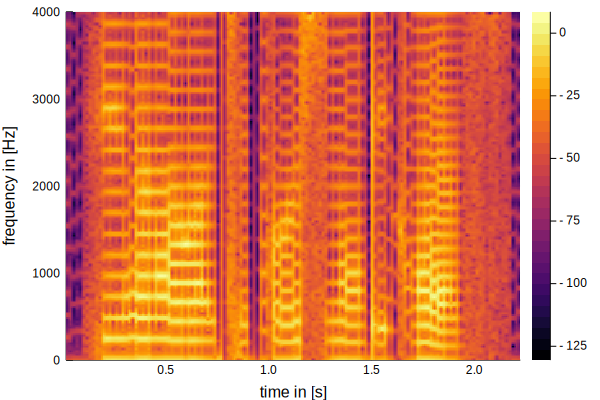

In [33]:
function withQuantisation(
        audio::Audio;
        m=12::Int, track=1::Int, threshold=.29::Float64)
    faudio = Sheet1.my_windowing(
        audio, frame_length=32e-3, frame_shift=32e-3)
    zi = zeros(m-1)
    result = zeros(0)
    counter = 0
    for i in 1:numFrames(faudio)
        s = faudio.frames[:,track,i]
        ff = Sheet1.fundamentalFrequencyEstimator(s,
            samplingRate(faudio))
        ff = ffCoder([ff], 4)[1]                                   # (1)
        voiced, counter = voicedS(length(s), samplingRate(faudio),
            freq=ff, counter=counter)
        excitation =
            Sheet5.isVoiced(s, threshold=threshold) ?
            voiced :
            unvoiced(length(s))
        lpc_coeff = lpcCoder(Sheet3.lpc(s, m=m), 6)                   # (4)
        out, zi = Sheet5.filterAdaptively(
            [1.0], vcat(1,lpc_coeff), excitation, zi=zi)
        s_power = logPowerCoder([Sheet5.computePower(s)], 4)[1]    # (2) / (3)
        α = sqrt(s_power                                           # (2)
            / Sheet5.computePower(out))
        append!(result, α * out)
    end
    loadAudio(result, samplingRate(audio))
end
female_quantised = withQuantisation(female, m=4);
#playAudio(female_quantised)
Sheet2.my_spectrogram(Sheet2.my_stft(
        Sheet2.applyWindow(Sheet1.my_windowing(female_quantised))))

### 4.5) Data rate

| parameter        | bits / frame |
|------------------|--------------|
| voiced/unvoiced  |            1 |
| frequency        |            4 |
| signal power     |            4 |
| LPC coefficients |         4x 6 |
| total            |           33 |

At `1/16e-3 = 62.5` frames per second we therefore have a bitrate of `33 * 62.5 = 2062.5` bits per second or `2.1 kb/s`.


In comparison, if we wanted to quantise each sample at 16 bits per sample, we would get a bit rate of 128 kb/s:

In [34]:
rate = 8000.0
bitrate_in_kbit_per_second = 8000.0 * 16 / 1000

128.0

The price we pay for the heavily reduced bit rate is of course the reduced sound quality.
While we may understand what is being said, and while we can distinguish questions from statements, the voice clearly sounds artificial.

One idea to fix this quality issue while retaining the same low bit rate has been proposed by [W. Bastiaan Kleijn from Cornell University Library](https://auphonic.com/blog/2018/06/01/codec2-podcast-on-floppy-disk/).
Instead of using our naive speech synthesis process (remember that it uses a simple pulse train to simulate the vocal cords) a neural network learns how to optimally recreate speech from the features we extracted.